In [ ]:
import pandas as pd
from IPython.display import display

# EDA

- `Image` and `Variants` column, if my understanding is correct, have the identical image. The `Image` column has an actual image while the `Variants` has the link to the Amazon site for that specific product. A lot of those products are not on Amazon anymore so the link leads to an error.

In [ ]:
df = pd.read_csv('/Users/brunamedeiros/Documents/GitHub/Amazon-Multimodal-Chatbot/data.csv')


In [ ]:

print("="*60)
print("Entire dataset:")
print("="*60)
display(df.head(5))

print("="*60)
print("Dataset shape:")
print("="*60)
print(df.shape)


print("\n")
print("="*60)
print("Columns in the dataset:")
print("="*60)
print(df.columns.tolist())

print("\n")
print("="*60)
print("Column types:")
print("="*60)
print(df.dtypes)

print("\n")
print("="*60)
print("NaN counts:")
print("="*60)
print(df.isna().sum())

print("\n")
print("="*60)
print("Columns where all values are NaN:")
print("="*60)
print("The columns that should be removed because all values are NaN are:")
for col in df.columns:
    if df[col].isna().sum() == df.shape[0]:
        print(f"  {col}")


print("\n")
print("="*60)
print("Columns we can work with")
print("="*60)

for col in df.columns:
    if df[col].isna().sum() != df.shape[0]:
        print(f"  {col}")
valid_cols = [col for col in df.columns if df[col].isna().sum() != df.shape[0]]
display(df[valid_cols].head(3))


Entire dataset:


,Uniq Id,Product Name,Brand Name,Asin,Category,Upc Ean Code,List Price,Selling Price,Quantity,Model Number,...,Product Url,Stock,Product Details,Dimensions,Color,Ingredients,Direction To Use,Is Amazon Seller,Size Quantity Variant,Product Description
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",NaN,NaN,Sports & Outdoors | Outdoor Recreation | Skate...,NaN,NaN,$237.68,NaN,NaN,...,https://www.amazon.com/DB-Longboards-CoreFlex-...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",NaN,NaN,Toys & Games | Learning & Education | Science ...,NaN,NaN,$99.95,NaN,55324,...,https://www.amazon.com/Electronic-Circuits-Cla...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,NaN,NaN,Toys & Games | Arts & Crafts | Craft Kits,NaN,NaN,$34.99,NaN,NaN,...,https://www.amazon.com/3Doodler-Plastic-Innova...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
3,18018b6bc416dab347b1b7db79994afa,Guillow Airplane Design Studio with Travel Cas...,NaN,NaN,Toys & Games | Hobbies | Models & Model Kits |...,NaN,NaN,$28.91,NaN,142,...,https://www.amazon.com/Guillow-Airplane-Design...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
4,e04b990e95bf73bbe6a3fa09785d7cd0,Woodstock- Collage 500 pc Puzzle,NaN,NaN,Toys & Games | Puzzles | Jigsaw Puzzles,NaN,NaN,$17.49,NaN,62151,...,https://www.amazon.com/Woodstock-Collage-500-p...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN


Dataset shape:
(10002, 28)


Columns in the dataset:
['Uniq Id', 'Product Name', 'Brand Name', 'Asin', 'Category', 'Upc Ean Code', 'List Price', 'Selling Price', 'Quantity', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Product Dimensions', 'Image', 'Variants', 'Sku', 'Product Url', 'Stock', 'Product Details', 'Dimensions', 'Color', 'Ingredients', 'Direction To Use', 'Is Amazon Seller', 'Size Quantity Variant', 'Product Description']


Column types:
Uniq Id                   object
Product Name              object
Brand Name               float64
Asin                     float64
Category                  object
Upc Ean Code              object
List Price               float64
Selling Price             object
Quantity                 float64
Model Number              object
About Product             object
Product Specification     object
Technical Details         object
Shipping Weight           object
Product Dimensions        objec

,Uniq Id,Product Name,Category,Upc Ean Code,Selling Price,Model Number,About Product,Product Specification,Technical Details,Shipping Weight,Product Dimensions,Image,Variants,Product Url,Is Amazon Seller
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Sports & Outdoors | Outdoor Recreation | Skate...,NaN,$237.68,NaN,Make sure this fits by entering your model num...,Shipping Weight: 10.7 pounds (View shipping ra...,NaN,10.7 pounds,NaN,https://images-na.ssl-images-amazon.com/images...,https://www.amazon.com/DB-Longboards-CoreFlex-...,https://www.amazon.com/DB-Longboards-CoreFlex-...,Y
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",Toys & Games | Learning & Education | Science ...,NaN,$99.95,55324,Make sure this fits by entering your model num...,Product Dimensions: 14.7 x 11.1 x 10.2...,The snap circuits mini kits classpack provides...,4 pounds,14.7 x 11.1 x 10.2 inches 4.06 pounds,https://images-na.ssl-images-amazon.com/images...,NaN,https://www.amazon.com/Electronic-Circuits-Cla...,Y
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,Toys & Games | Arts & Crafts | Craft Kits,NaN,$34.99,NaN,Make sure this fits by entering your model num...,ProductDimensions:10.3x3.4x0.8inches|ItemWeigh...,show up to 2 reviews by default No longer are ...,12.8 ounces,NaN,https://images-na.ssl-images-amazon.com/images...,NaN,https://www.amazon.com/3Doodler-Plastic-Innova...,Y


# Data Cleaning
- Strip `Uniq id` column, as we will use that as naming for the images and metadata for embedding. we are using .strip() to ensure no errors arise later

In [15]:
print("Cleaning Uniq Id column (.strip())...")
df['Uniq Id'] = df['Uniq Id'].astype(str).str.strip()
print()
print(df['Uniq Id'].head())

# Check for any issues
print(f"\nUnique IDs: {df['Uniq Id'].nunique()}")
print(f"Any duplicates: {df['Uniq Id'].duplicated().sum()}")

Cleaning Uniq Id column (.strip())...

0    4c69b61db1fc16e7013b43fc926e502d
1    66d49bbed043f5be260fa9f7fbff5957
2    2c55cae269aebf53838484b0d7dd931a
3    18018b6bc416dab347b1b7db79994afa
4    e04b990e95bf73bbe6a3fa09785d7cd0
Name: Uniq Id, dtype: object

Unique IDs: 10002
Any duplicates: 0


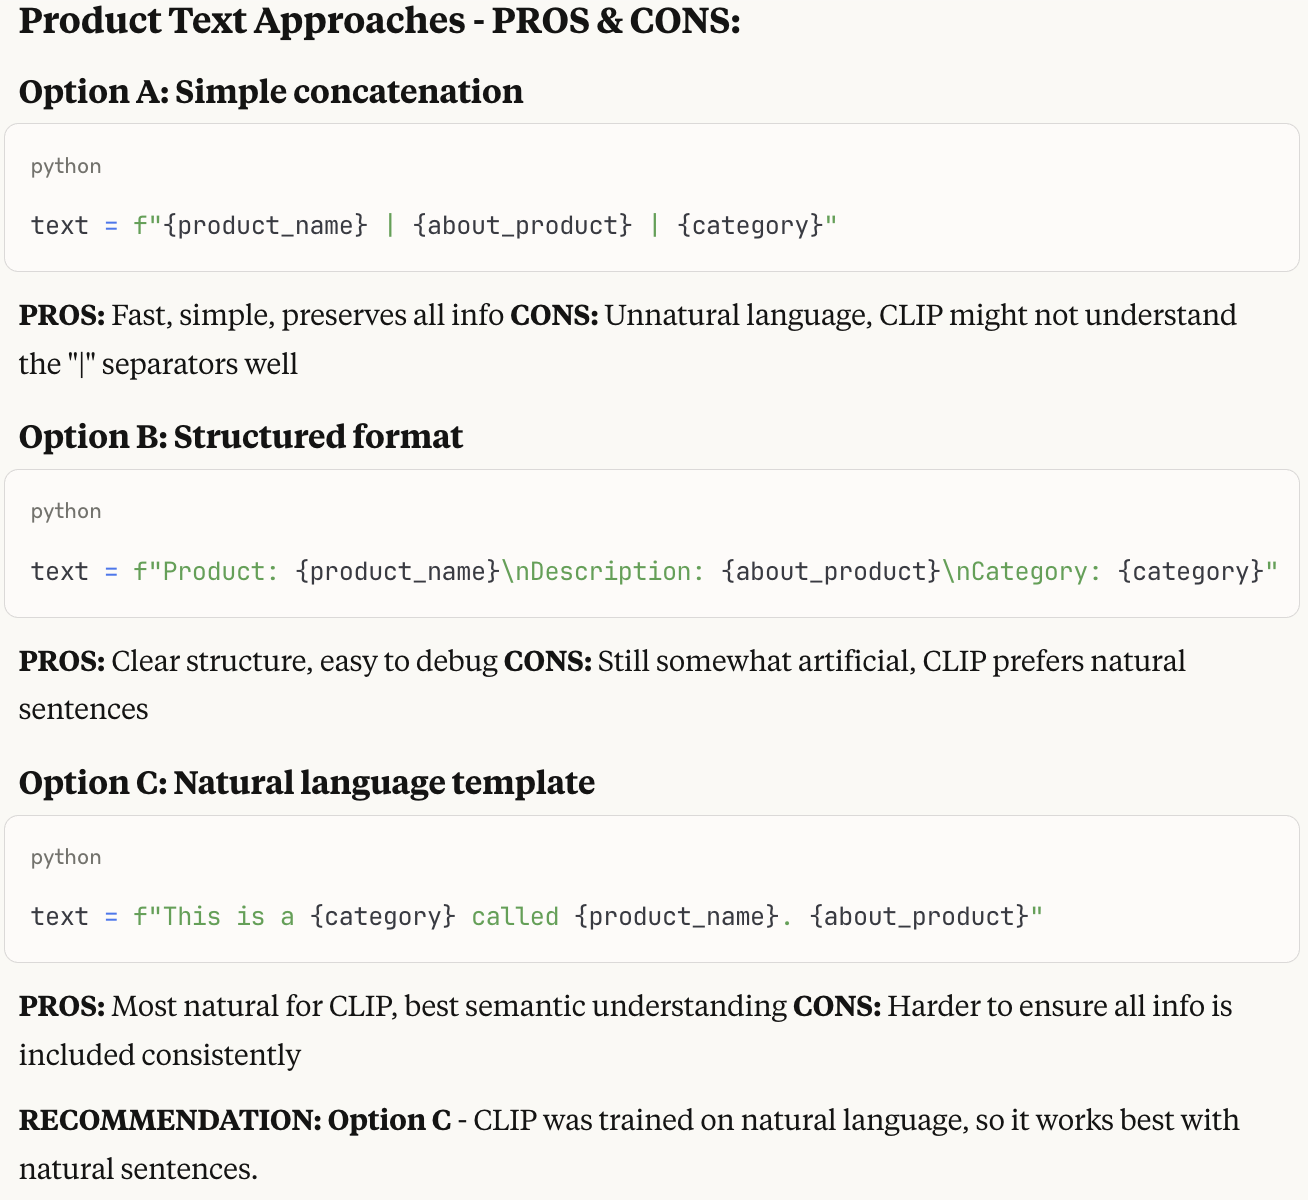
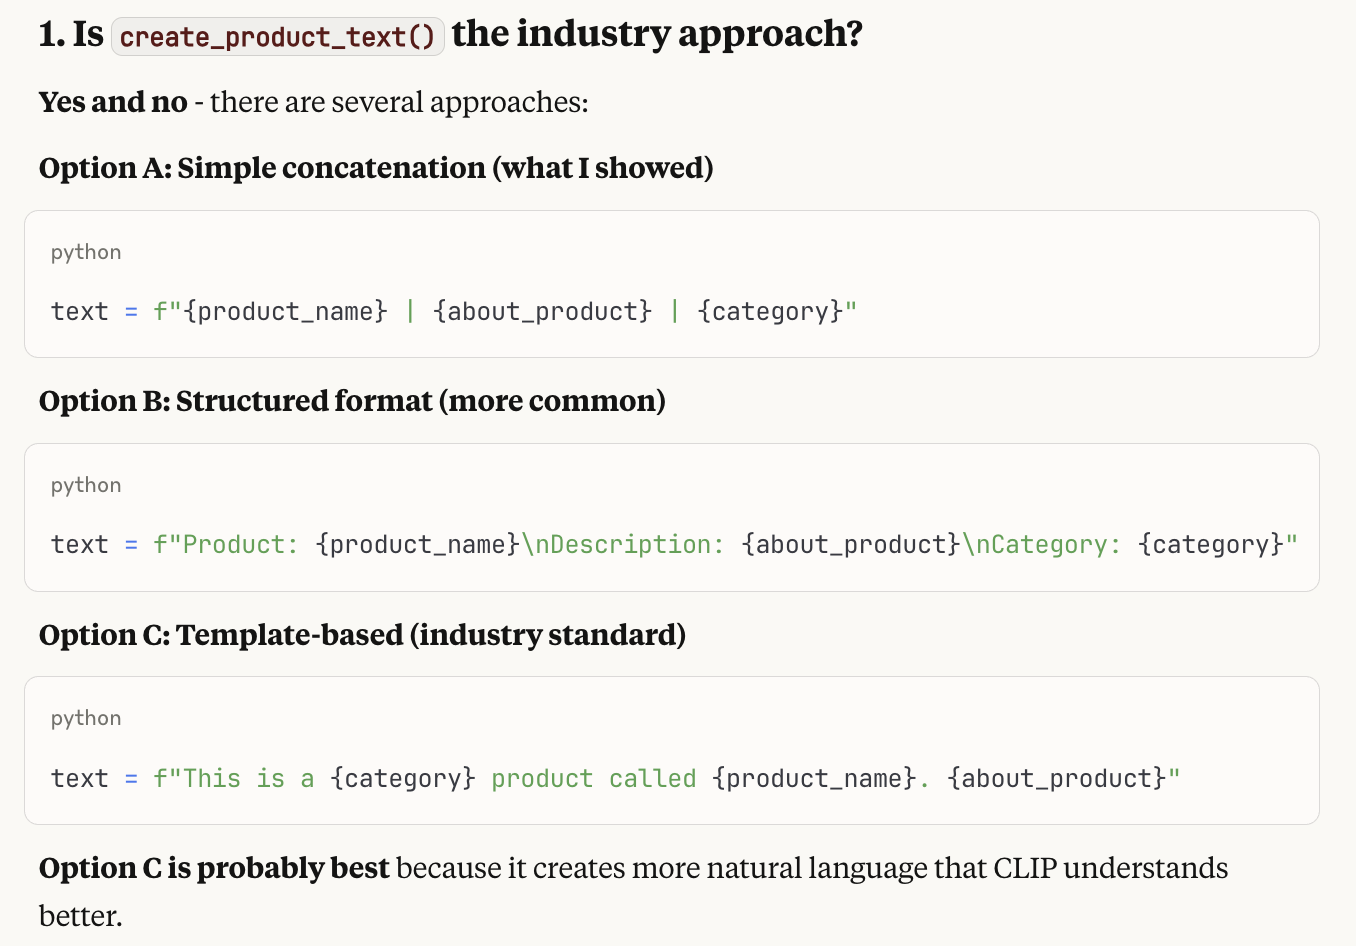

# Image Embedding

Each inidivual row under `Image` column has more than one https link in it.

For instance, row 1: `https://images-na.ssl-images-amazon.com/images/I/51j3fPQTQkL.jpg|https://images-na.ssl-images-amazon.com/images/I/31hKM3cSoSL.jpg|https://images-na.ssl-images-amazon.com/images/I/51WlHdwghfL.jpg|https://images-na.ssl-images-amazon.com/images/I/51FsyLRBzwL.jpg|https://images-na.ssl-images-amazon.com/images/G/01/x-locale/common/transparent-pixel.jpg`

Each product has more than 1 image (showing different perspectives of product). Instead of putting them in a different column, they concatenated all URLs in the same one, dividing them by the |

---

The `download_first_image` does the following (**WE DIDN'T USE THIS ONE**):
- separate the many https through the |
- skip the transparent pixel
    - the transparent pixel is a 1x1 pixel invisible image that Amazon uses a placeholder/tracking pixel.It looks like this `https://images-na.ssl-images-amazon.com/images/G/01/x-locale/common/transparent-pixel.jpg`. It's literally a transparent image Amazon uses for things such as web tracking, analytics, layout spacing... Therefore, we need to remove it, or else our CLIP model will try to embed an empty image).
- Saves one image per product
    - Majority of products (cell in `Image` column) have more than 1 image per product. We could either save 1 image per product or save all images per product. This function only saves one image per product as it is more feasible with the project deadline. It would be much more complex to handle CLIP if we were to have more than 1 image
- Name images as the `Uniq Id`: easy to look up
    - When we connect to Chroma and create embeddings, we can store `Uniq Id` as metadata

In [ ]:
# THIS CODE WAS TO SAVE IMAGES LOCALLY. I'LL TRY TO EMBED THEM DIRECTLY WITHOUT SAVINNG

# import requests
# from PIL import Image
# from io import BytesIO
# import os

# os.makedirs('images', exist_ok=True)

# def download_first_image(url_string, filename):
#     """Download image from URL - savie on local - no embeddings"""
#     try:
#         # split by | and get all urls
#         urls = url_string.split('|')

#         # find first URL that is not a transparent pixel
#         for url in urls:
#             url = url.strip()
#             if 'transparent-pixel.jpg' not in url:
#                 print(f"Trying: {url}")

#                 # download to local
#                 response = requests.get(url)
#                 if response.status_code == 200:

#                     # save to local
#                     image = Image.open(BytesIO(response.content))
#                     image_path = f"images/{filename}.jpg"
#                     image.save(image_path)
#                     print(f"Saved: {image_path}")
#                     return image_path
#                 else:
#                     print(f"ERROR: Status {response.status_code} for {url}")
        
#         print("No valid images found")
#         return None
    
#     except Exception as e:
#         print(f"ERROR: {e}")
#         return None
    
# # test for 3 images
# # for i in range(3):
# #     if i < len(df) and pd.notna(df['Image'].iloc[i]):
# #         url_string = df['Image'].iloc[i]   # Get the Image value from row i
# #         uniq_id = df['Uniq Id'].iloc[i]    # Get the Uniq Id value from row i
# #         print(f"\n--- Processing product {i}: ID {uniq_id} ---")
# #         download_first_image(url_string, uniq_id)

# # since it worked, we'll now do for all images


# # for ALL images with duplicate checl
# for i in range(len(df)):
#     if pd.notna(df['Image'].iloc[i]):
#         url_string = df['Image'].iloc[i]   # Get the Image value from row i
#         uniq_id = df['Uniq Id'].iloc[i]    # Get the Uniq Id value from row i

#         # check if image already exists
#         image_path = f"images/{uniq_id}.jpg"
#         if os.path.exists(image_path):
#             print(f"Skipping {uniq_id} - already exists")
#             continue # skip to next iteration
        
#         print(f"\n--- Processing product {i}: ID {uniq_id} ---")
#         download_first_image(url_string, uniq_id)

`download_first_image` was the first attempt. now we changed to `get_image_embedding_from_url`. It does the same as the previous one but:
- doesn't save images locally. It processes image and automatically embed them into chroma.

In [46]:
import requests
from PIL import Image
from io import BytesIO
import pandas as pd

from transformers import CLIPProcessor, CLIPModel
import torch

import chromadb


model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_image_embedding(image):
    inputs = processor(images=[image], return_tensors="pt", padding=True)
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.numpy()[0]


# LIGHTER METADATA
def get_image_embedding_from_url(url_string, uniq_id):
    """Download image from URL and get CLIP embedding + metadata - no saving on local"""
    try:
        # split by | and get all urls
        urls = url_string.split('|')

        # find first URL that is not a transparent pixel
        for url in urls:
            url = url.strip()
            if 'transparent-pixel.jpg' not in url:
                print(f"Trying: {url}")

                # download to memory (not disk)
                response = requests.get(url)
                if response.status_code == 200:
                    # get image
                    image = Image.open(BytesIO(response.content))

                    # get CLIP embedding
                    embedding = get_image_embedding(image) # This just returns a numpy array - no metadata! I NEED TO ADD METADATA

                    # Create Metadata
                    metadata = {
                        "uniq_id": str(uniq_id),
                        "type": "image"
                    }

                    #print(f"Got embedding for {uniq_id}")
                    return embedding, metadata
        
        # If no URLs worked
        print(f"No valid URLs found for {uniq_id}")
        return None, None

    except Exception as e:
        print(f"ERROR: {e}")
        return None, None


# Create/connect to vector store
client = chromadb.PersistentClient(path="./my_vectorstore")  # ← This is the "name"
collection = client.get_or_create_collection(name="amazon_products")

# BATCH PROCESSING SETUP
BATCH_SIZE = 100  # Process 100 images at a time
embeddings_to_store = []
metadatas_to_store = []
ids_to_store = []

    
# # Check/delete existing data
# print(f"Current embeddings in store: {collection.count()}\n")
# if collection.count() > 0:
#     response = input("Delete existing data? (y/n): ")
#     if response.lower() == 'y':
#         all_data = collection.get()
#         collection.delete(ids=all_data['ids'])
#         print("Deleted existing data\n")


# EMBED 
for i in range(len(df)):
    if i < len(df) and pd.notna(df['Image'].iloc[i]):
        uniq_id = df['Uniq Id'].iloc[i]  # Just get uniq_id

        # CHECK: Skip if already exists
        try:
            existing = collection.get(ids=[f"img_{uniq_id}"])
            if existing['ids']:  # If it exists, skip
                print(f"Skipping {uniq_id} - already exists")
                continue
        except:
            pass  # Doesn't exist, continue processing

        url_string = df['Image'].iloc[i]

        embedding, metadata = get_image_embedding_from_url(url_string, uniq_id)  # Pass uniq_id
        if embedding is not None:
            embeddings_to_store.append(embedding.tolist())  # Convert to list
            metadatas_to_store.append(metadata)
            ids_to_store.append(f"img_{uniq_id}")  # Unique ID for Chroma
            
            #print(f"Embedding shape: {embedding.shape}")
            #print("Metadata:", metadata)
            #print("-" * 50)
        
        # Store every BATCH_SIZE embeddings
        if len(embeddings_to_store) >= BATCH_SIZE:
            collection.add(embeddings=embeddings_to_store, metadatas=metadatas_to_store, ids=ids_to_store)
            print(f"Stored batch of {len(embeddings_to_store)} embeddings")
            # Clear lists for next batch
            embeddings_to_store = []
            metadatas_to_store = []
            ids_to_store = []

# # Store all embeddings at once
# if embeddings_to_store:
#     collection.add(
#         embeddings=embeddings_to_store,
#         metadatas=metadatas_to_store,
#         ids=ids_to_store
#     )
#     print(f"Stored {len(embeddings_to_store)} embeddings in vector store!")

# Store final batch (if any remaining)
if embeddings_to_store:
    collection.add(embeddings=embeddings_to_store, metadatas=metadatas_to_store, ids=ids_to_store)
    print(f"Stored final batch of {len(embeddings_to_store)} embeddings")


Skipping 4c69b61db1fc16e7013b43fc926e502d - already exists
Skipping 66d49bbed043f5be260fa9f7fbff5957 - already exists
Skipping 2c55cae269aebf53838484b0d7dd931a - already exists
Skipping 18018b6bc416dab347b1b7db79994afa - already exists
Skipping e04b990e95bf73bbe6a3fa09785d7cd0 - already exists
Skipping f8c32a45e507a177992973cf0d46d20c - already exists
Skipping 40d3cd16b41970ae6872e914aecf2c8e - already exists
Skipping bc178f33a04dbccefa95b165f8b56830 - already exists
Skipping cc2083338a16c3fe2f7895289d2e98fe - already exists
Skipping 69828c5570dcdbd1609216d33fbad0db - already exists
Skipping 7b0746d8afc8462ba17f8a763d9d5f1e - already exists
Skipping c5f4c94653a3befd8dd16adf2914c04e - already exists
Skipping 615ba903c134f439eaf8cdd1678ceb5c - already exists
Skipping 82c86a4d24dce5e14303033d7b658b78 - already exists
Skipping 1ecccb43e0f5c0162218371916ffa553 - already exists
Skipping d1ac6d805fcdf75f9e00af611dd03ce4 - already exists
Skipping d82015ffbf4cd54b0edfb890002971f3 - already exis

In [48]:
# Get vector store info (FIXED)
print("📊 VECTOR STORE INFO:")
print(f"Collection name: {collection.name}")
print(f"Total embeddings: {collection.count()}")

# Check what's inside
if collection.count() > 0:
    peek = collection.peek(limit=3)
    print(f"\nSample IDs: {peek['ids']}")
    print(f"\nSample metadata: {peek['metadatas']}")
else:
    print("No embeddings stored yet")

# List all collections
print(f"All collections: {client.list_collections()}")


print(f"\nVector store folder exists: {os.path.exists('./my_vectorstore')}")
if os.path.exists('./my_vectorstore'):
    print(f"Folder contents: {os.listdir('./my_vectorstore')}")

📊 VECTOR STORE INFO:
Collection name: amazon_products
Total embeddings: 9980

Sample IDs: ['img_4c69b61db1fc16e7013b43fc926e502d', 'img_66d49bbed043f5be260fa9f7fbff5957', 'img_2c55cae269aebf53838484b0d7dd931a']

Sample metadata: [{'uniq_id': '4c69b61db1fc16e7013b43fc926e502d', 'type': 'image'}, {'type': 'image', 'uniq_id': '66d49bbed043f5be260fa9f7fbff5957'}, {'uniq_id': '2c55cae269aebf53838484b0d7dd931a', 'type': 'image'}]
All collections: [Collection(name=amazon_products)]

Vector store folder exists: True
Folder contents: ['chroma.sqlite3', 'c554e119-0db2-4688-9da7-fdb67c76d823']


`Sample IDs` = Chroma's interal IDs (chroma's way of finding embedding)

`Uniq ID` = our product ID in metadata

# Text Embedding - needs to be completed

bash```

text_columns = [
    'Product Name',
    'Category',
    'Selling Price',
    'Model Number',
    'About Product',
    'Technical Details',
    'Shipping Weight',
    'Product Dimensions',
    'Is Amazon Seller',
    'product url'
]

image_columns = ['image']
```

In [ ]:
# load clip
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# # text embeddings
# def get_text_embedding(text):
#     inputs = processor(text=[text], return_tensors="pt", padding=True)
#     with torch.no_grad():
#         embedding = model.get_text_features(**inputs)
#     return embedding.numpy()[0]

# # image embeddings
# def get_image_embedding(image):
#     inputs = processor(images=[image], return_tensors="pt", padding=True)
#     with torch.no_grad():
#         embedding = model.get_image_features(**inputs)
#     return embedding.numpy()[0]


# For images
image_embedding = get_image_embedding(image)
metadata = {
    "uniq_id": row['Uniq Id'],
    "product_name": row['Product Name'],
    "type": "image"
}

# For text  
text_embedding = get_text_embedding(product_text)
metadata = {
    "uniq_id": row['Uniq Id'], 
    "product_name": row['Product Name'],
    "type": "text"
}

In [ ]:
# Test text
text_emb = get_text_embedding("Samsung Galaxy phone")
print(f"Text embedding shape: {text_emb.shape}")

# Test image (dummy)
dummy_img = Image.new('RGB', (224, 224), color='red')
img_emb = get_image_embedding(dummy_img)  
print(f"Image embedding shape: {img_emb.shape}")

# Test similarity
similarity = np.dot(text_emb, img_emb) / (np.linalg.norm(text_emb) * np.linalg.norm(img_emb))
print(f"Text-image similarity: {similarity:.3f}")


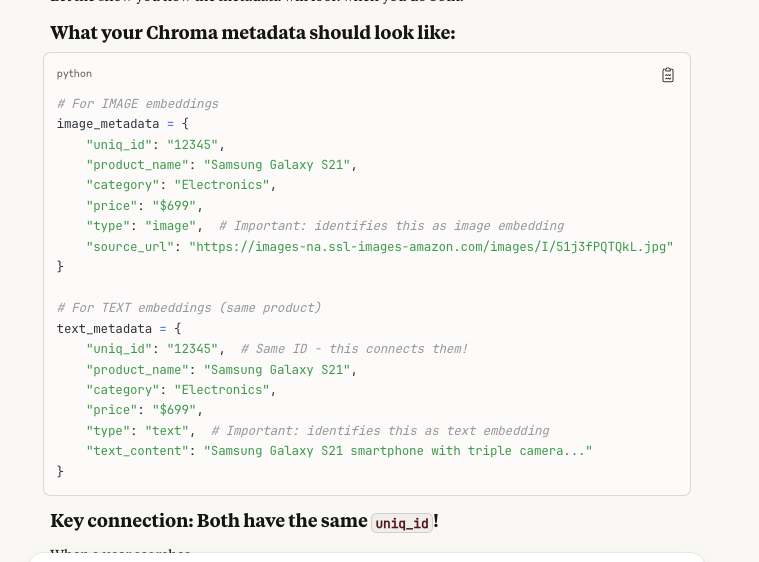

# OLD CODE

In [29]:
# HEAVIER METADATA
# def get_image_embedding_from_url(url_string, product_row):
#     """Download image from URL and get CLIP embedding + metadata - no saving on local"""
#     try:
#         uniq_id = product_row['Uniq Id']

#         # split by | and get all urls
#         urls = url_string.split('|')

#         # find first URL that is not a transparent pixel
#         for url in urls:
#             url = url.strip()
#             if 'transparent-pixel.jpg' not in url:
#                 print(f"Trying: {url}")

#                 # download to memory (not disk)
#                 response = requests.get(url)
#                 if response.status_code == 200:
#                     # get image
#                     image = Image.open(BytesIO(response.content))

#                     # get CLIP embedding
#                     embedding = get_image_embedding(image) # This just returns a numpy array - no metadata! I NEED TO ADD METADATA

#                     # Create Metadata

#                     # # very heavy metadata option
#                     # metadata = {
#                     #     "uniq_id": str(uniq_id),
#                     #     "product_name": product_row['Product Name'],
#                     #     "category": product_row['Category'],
#                     #     "price": str(product_row['Selling Price']),
#                     #     "type": "image", # Important: identifies this as image embedding. It is "text" for text
#                     #     "source_url": url
#                     # }

#                     print(f"Got embedding for {uniq_id}")
#                     return embedding, metadata

#     except Exception as e:
#         print(f"ERROR: {e}")
#         return None, None